# Hypergraph information

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from itertools import combinations
import random

sys.path.append("../src/")

import xgi
from reducibility_hg import *

from statannotations.Annotator import Annotator

sb.set_theme(style="ticks", context="paper")

In [2]:
results_dir = "../results/"
out_dir  = f"{results_dir}synthetic/"

In [3]:
def optimization_rescaled(H, tau, rescaling_factors, rescale_per_node=False, sparse=False):

    orders = np.array(xgi.unique_edge_sizes(H)) - 1
    weights = np.ones(len(orders))
    L_multi = xgi.multiorder_laplacian(
        H, orders, weights, rescale_per_node=rescale_per_node, sparse=sparse
    )

    rho_all = density(L_multi, tau, sparse=sparse)

    D = []  # Learning error
    lZ = []  # Penalization term for model complexity

    for l in range(len(orders)):
        L_l = xgi.multiorder_laplacian(
            H, orders[0 : l + 1], weights[0 : l + 1], rescale_per_node=rescale_per_node, sparse=sparse
        )
        rho_l = density(L_l, tau*rescaling_factors[l], sparse=sparse)
        d = KL(rho_all, rho_l, sparse=sparse)
        z = penalization(L_l, tau*rescaling_factors[l], sparse=sparse)

        D.append(d)
        lZ.append(z)

    lZ = np.array(lZ)
    D = np.array(D)

    return D, lZ

def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [np.pad(a, (0, max_shape-a.shape[0]), mode='constant', constant_values=None) for a in arr_list]
    return padded_arr_list

In [4]:
def plot_3panels(info_losses, complexities, orders, labels, legend_title=None):
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2.1), constrained_layout=True, sharey=True)

    n = len(info_losses)
    
    for i in range(n):
        ax1.plot(orders[i], info_losses[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)      

    ax1.set_title("Information Loss (KL)")
    ax1.set_xlabel("Max Order")
    ax1.set_ylabel("Bits")
    
    for i in range(n):
        ax2.plot(orders[i], complexities[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)      

    ax2.set_title("Model Complexity ($\delta S$)")
    ax2.set_xlabel("Max Order")
    
    for i in range(n):
        message_length = complexities[i] + info_losses[i]
        ax3.plot(orders[i], message_length, "o-", label=labels[i], ms=7, mfc="w", lw=2)

    ax3.legend(title=legend_title, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left")

    ax3.set_title("Message Length")
    ax3.set_xlabel("Max Order")

    sb.despine()

    #fig.suptitle(f"Complete hypergraph N={N}")

    #fig_name = f"message_length_complete_hypergraph_N{N}" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

    #plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
    
    return fig, (ax1, ax2, ax3)

In [4]:
rf_1 = 1
rf_2 = rf_1 + 2
rf_3 = rf_2 + 3
rf_4 = rf_3 + 4
inverse_rescaling_factors = np.array([1/rf_1, 1/rf_2, 1/rf_3, 1/rf_4]) * rf_4

## Filling hyperedges of order 5

In [15]:
N = 100
possible_hyperedges = list(combinations(range(N), 5))

Hs = dict()
for d in [50,100,500,1000,5000]:
    Hs_i = []
    for rep in range(50): 
        if (rep+1)%50==0:
            print(rep+1)
        hyperedges = random.sample(possible_hyperedges, d)
        H = xgi.SimplicialComplex(hyperedges)

        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))

        Hs_i.append(H)
    Hs[d] = Hs_i 

50
50
50
50
50


In [16]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for d, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=True)
        inverse_rescaling_factors = [max(orders) / d for d in orders]
        Ds_H, lZs_H = optimization_rescaled(H,tau_c, inverse_rescaling_factors, rescale_per_node=True)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[d] = info_losses_i
    complexities[d] = complexities_i
    orders_arr[d] = orders_arr_i
    message_lengths[d]= message_lengths_i      

In [22]:
for i, s in enumerate([50,100,500,1000,5000]):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["number of edges", "rep"]).melt(
    id_vars=["number of edges", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

500_3 vs. 500_4: Welch's t-test independent samples, P_val:2.622e-02 t=-2.257e+00
1000_3 vs. 1000_4: Welch's t-test independent samples, P_val:1.804e-05 t=-4.510e+00
1000_1 vs. 1000_2: Welch's t-test independent samples, P_val:2.699e-01 t=1.110e+00
5000_1 vs. 5000_2: Welch's t-test independent samples, P_val:2.828e-12 t=7.978e+00
5000_2 vs. 5000_3: Welch's t-test independent samples, P_val:1.944e-04 t=-3.873e+00
100_3 vs. 100_4: Welch's t-test independent samples, P_val:6.907e-01 t=-3.991e-01
500_1 vs. 500_2: Welch's t-test independent samples, P_val:8.113e-04 t=-3.457e+00
50_3 vs. 50_4: Welch's t-test independent samples, P_val:8.537e-01 t=-1.849e-01
50_1 vs. 50_2: Welch's t-test independent samples, P_val:5.833e-01 t=-5.504e-01
50_2 vs. 50_3: Welch's t-test independent samples, P_val:7.517e-01 t=-3.173e-01

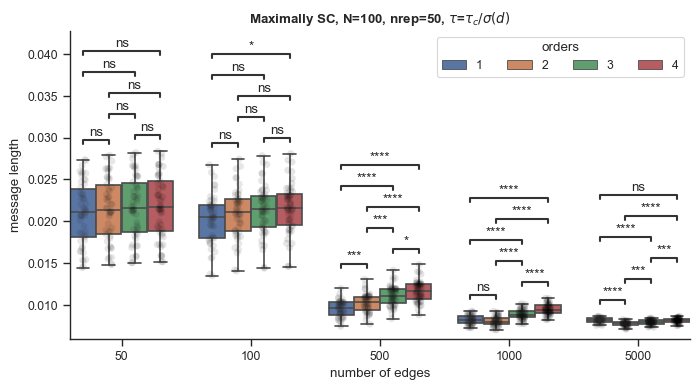

In [23]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(data=dff, hue="order", y="message length", x="number of edges", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="number of edges", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Maximally SC, N={N}, nrep={50}, $\tau$=$\tau_c/\sigma(d)$", weight="bold")


pairs = []
for p in [50,100,500,1000,5000]:
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="number of edges", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_MSC_N_100_d_50_100_250_500_1000_char_tau_1_rescaled_boxplot"
#plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

### Second eigenvalue, node and degree rescaling

In [24]:
N = 100
possible_hyperedges = list(combinations(range(N), 5))

Hs = dict()
for d in [50,100,500,1000,5000]:
    Hs_i = []
    for rep in range(50): 
        if (rep+1)%50==0:
            print(rep+1)
        hyperedges = random.sample(possible_hyperedges, d)
        H = xgi.SimplicialComplex(hyperedges)

        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))

        Hs_i.append(H)
    Hs[d] = Hs_i 

50
50
50
50


In [7]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for d, Hs_i in Hs.items():
    
    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []
    
    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=True, idx=1)
        inverse_rescaling_factors = [max(orders) / d for d in orders]
        Ds_H, lZs_H = optimization_rescaled(H,tau_c, inverse_rescaling_factors, rescale_per_node=True)
    
        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)
                  
    info_losses[d] = info_losses_i
    complexities[d] = complexities_i
    orders_arr[d] = orders_arr_i
    message_lengths[d]= message_lengths_i    

In [8]:
for i, s in enumerate([50,100,250,500,1000]):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]

dff = df.reset_index(names=["number of edges", "rep"]).melt(
    id_vars=["number of edges", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

250_3 vs. 250_4: Welch's t-test independent samples, P_val:9.876e-01 t=-1.555e-02
500_3 vs. 500_4: Welch's t-test independent samples, P_val:7.682e-01 t=-2.955e-01
500_1 vs. 500_2: Welch's t-test independent samples, P_val:6.974e-01 t=-3.900e-01
1000_1 vs. 1000_2: Welch's t-test independent samples, P_val:7.543e-01 t=3.138e-01
1000_2 vs. 1000_3: Welch's t-test independent samples, P_val:8.276e-02 t=-1.753e+00
100_3 vs. 100_4: Welch's t-test independent samples, P_val:8.963e-01 t=1.307e-01
250_1 vs. 250_2: Welch's t-test independent samples, P_val:9.734e-01 t=3.338e-02
50_3 vs. 50_4: Welch's t-test independent samples, P_val:9.628e-01 t=4.676e-02
50_1 vs. 50_2: Welch's t-test independent samples, P_val:7.965e-01 t=2.585e-01
50_2 vs. 50_3: Welch's t-test independent samples, P_val:9.261e-01 t=9.296e-02
100_1 v

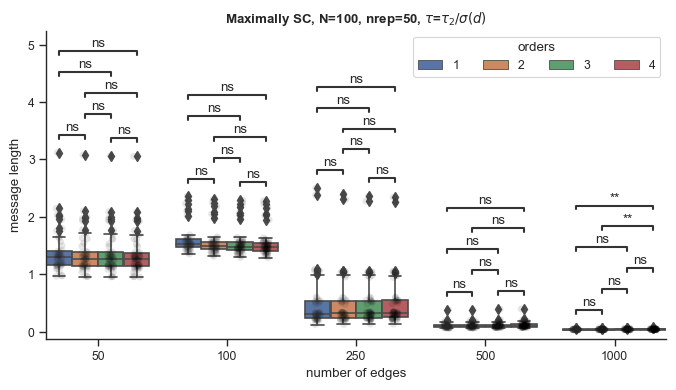

In [9]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(data=dff, hue="order", y="message length", x="number of edges", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 4)

sb.stripplot(data=dff, hue="order", y="message length", x="number of edges", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Maximally SC, N={N}, nrep={50}, $\tau$=$\tau_2/\sigma(d)$", weight="bold")


pairs = []
for p in [50,100,250,500,1000]:
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="number of edges", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_MSC_N_100_d_50_100_250_500_1000_char_tau2_1_rescaled_boxplot"
#plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")